In [1]:
import sys, os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *

In [2]:
with open('../data/params.json', 'r') as f:
    params = json.load(f)

nsim = params.get('nsim', 10000)
nepisode_train = params.get('nepisode_train', 3000)
nepisode_eval = params.get('nepisode_eval', 500)
nstep = params.get('nstep', 365)
t1 = params.get('t1', 0)
k = params.get('k', 100)

with open('../data/results.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.read_csv('../data/test_cases.csv', usecols=range(0, 14))


In [3]:
# df.head()
# mean_reward, fig1, fig2 = results[0]

In [4]:
# mean_rewards = []

# mean_reward

In [5]:
# show_figure(fig1)
# plt.show()

In [6]:
# mean_rewards = []
# for index, row in df.iterrows():
#     mean_reward = results[index][0]  
#     mean_rewards.append(mean_reward)
df['RL_Price'] = [x[0] for x in results]

In [7]:
df['European_Price'] = df.apply(
    lambda row: black_scholes(
        s=row['s_0'],
        k=k, 
        t1 = t1,
        t2=row['t2'],
        r=row['r'],
        v=row['v'] if not np.isnan(row['v']) else row['sigma'],  
        q = row['q'],
        call=row['h'].split('_')[-1].lower() == "call"
    ),
    axis=1
)

In [8]:
df['MC_Price'] = df.apply(
    lambda row: get_mc_price(
        generate_gbm_paths(
            nsim=1000,
            nstep=nstep,
            t1=t1,
            t2=row["t2"],
            s_0=row["s_0"],
            r=row["r"],
            q=row["q"],
            v=row["v"]
        ) if row["gbm"] else generate_heston_paths(
            nsim=1000,
            nstep=nstep,
            t1=t1,
            t2=row["t2"],
            s_0=row["s_0"],
            r=row["r"],
            q=row["q"],
            v_0=row["v_0"],
            theta=row["theta"],
            rho=row["rho"],
            kappa=row["kappa"],
            sigma=row["sigma"]
        ),
        t1=t1,
        t2=row["t2"],
        h=(call if row["h"].split('_')[-1].lower() == "call" else put), 
        k=k,
        r=row["r"]
    ),
    axis=1
)

In [9]:
# Relative differences
df["RL_vs_MC"] = (df["RL_Price"] - df["MC_Price"]) / df["MC_Price"]
df["RL_vs_European"] = (df["RL_Price"] - df["European_Price"]) / df["European_Price"]

# Value of Early Exercise
df['Early_Exe_Value_RL'] = df['RL_Price'] - df['European_Price']
df['Early_Exe_Value_MC'] = df['MC_Price'] - df['European_Price']

## Testing pricing consistency/accuracy on American Put-Options

### K = 100, r = 4%

In [ ]:
rel_col1 = ["s_0", "v", "t2", "RL_Price", "European_Price", "MC_Price"]
BC_gbm = df[(df["case"] == "Base_Case") & (df["gbm"] == True)]
BC_gbm[rel_col1]

,s_0,v,t2,RL_Price,European_Price,MC_Price
0,80,0.2,1.0,22.143752,17.784517,20.130523
2,80,0.2,2.0,22.917138,17.049533,20.063810
4,80,0.4,1.0,26.862564,23.409238,24.584343
6,80,0.4,2.0,29.560591,25.936587,27.371843
8,90,0.2,1.0,13.838910,10.841383,11.631390
10,90,0.2,2.0,15.372856,11.448371,13.584631
12,90,0.4,1.0,19.156382,17.981800,18.365346
14,90,0.4,2.0,21.113964,21.476312,22.965173
16,100,0.2,1.0,5.745424,6.003998,6.763260
18,100,0.2,2.0,8.536513,7.396337,8.660070


In [29]:
rel_col_h = ["s_0", 'v_0', 'theta', 'rho', 'kappa', 'sigma', "t2", "RL_Price", "European_Price", "MC_Price"]
BC_hest = df[(df["case"] == "Base_Case") & (df["gbm"] == False)]
BC_hest[rel_col_h]

,s_0,v_0,theta,rho,kappa,sigma,t2,RL_Price,European_Price,MC_Price
1,80,0.04,0.04,-0.7,2.0,0.2,1.0,23.462960,17.784517,20.015990
3,80,0.04,0.04,-0.7,2.0,0.2,2.0,24.463557,17.049533,20.034495
5,80,0.16,0.16,-0.7,2.0,0.4,1.0,27.396500,23.409238,23.420717
7,80,0.16,0.16,-0.7,2.0,0.4,2.0,30.805522,25.936587,25.618301
9,90,0.04,0.04,-0.7,2.0,0.2,1.0,14.070079,10.841383,11.518706
11,90,0.04,0.04,-0.7,2.0,0.2,2.0,15.702920,11.448371,13.188654
13,90,0.16,0.16,-0.7,2.0,0.4,1.0,18.751305,17.981800,18.838598
15,90,0.16,0.16,-0.7,2.0,0.4,2.0,23.054861,21.476312,23.041077
17,100,0.04,0.04,-0.7,2.0,0.2,1.0,6.186808,6.003998,5.980165
19,100,0.04,0.04,-0.7,2.0,0.2,2.0,7.700248,7.396337,8.874320


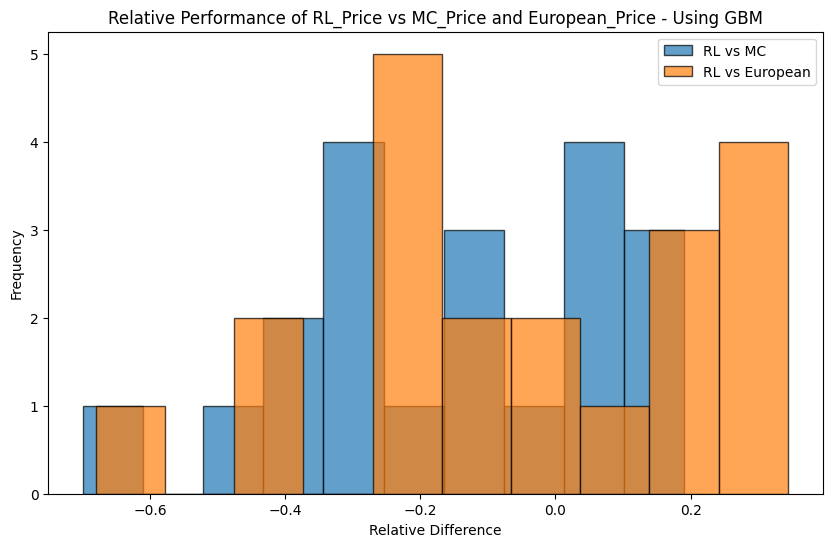

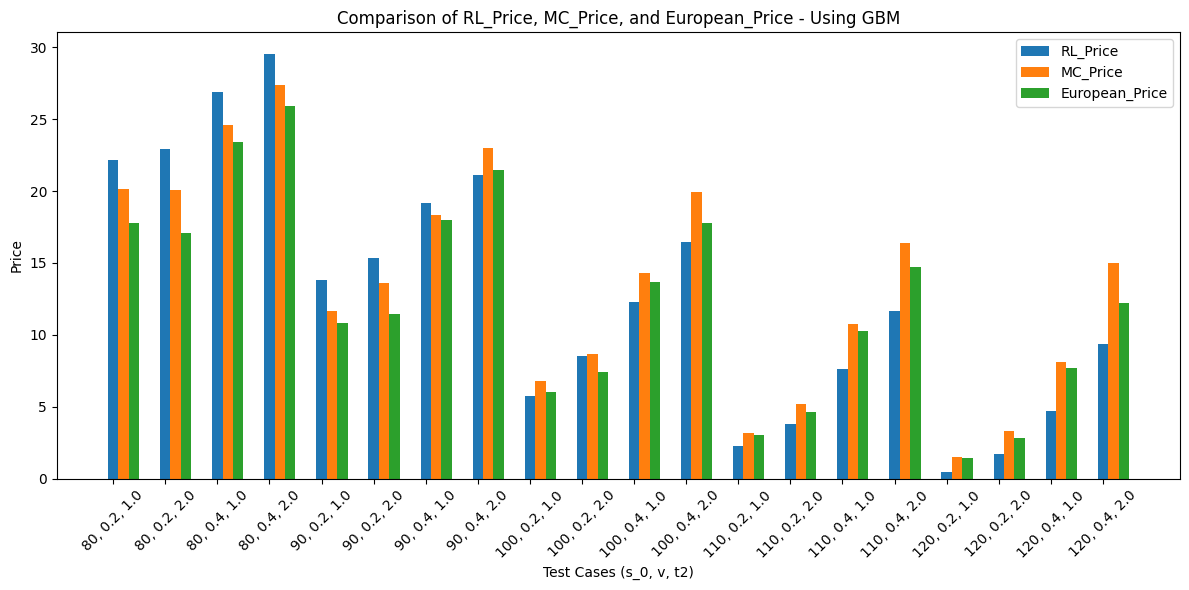

In [48]:
# Relative Performance
plt.figure(figsize=(10, 6))
plt.hist(BC_gbm["RL_vs_MC"], bins=10, alpha=0.7, label="RL vs MC", edgecolor="black")
plt.hist(BC_gbm["RL_vs_European"], bins=10, alpha=0.7, label="RL vs European", edgecolor="black")
plt.title("Relative Performance of RL_Price vs MC_Price and European_Price - Using GBM")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Comparing RL_Price, MC_Price, and European_Price
plt.figure(figsize=(12, 6))
x = range(len(BC_gbm))
plt.bar(x, BC_gbm["RL_Price"], width=0.2, label="RL_Price")
plt.bar([i + 0.2 for i in x], BC_gbm["MC_Price"], width=0.2, label="MC_Price")
plt.bar([i + 0.4 for i in x], BC_gbm["European_Price"], width=0.2, label="European_Price")
plt.xticks(x, [f"{row['s_0']}, {row['v']}, {row['t2']}" for _, row in BC_gbm.iterrows()], rotation=45)
plt.title("Comparison of RL_Price, MC_Price, and European_Price - Using GBM")
plt.xlabel("Test Cases (s_0, v, t2)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

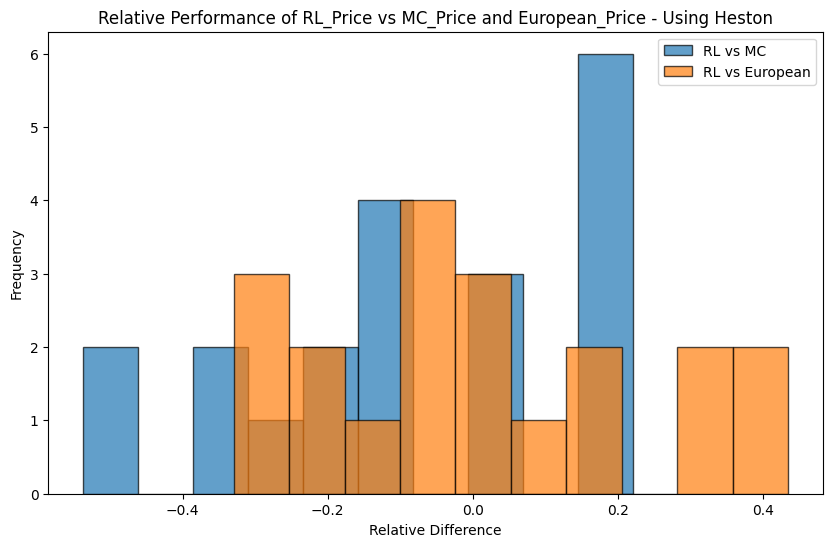

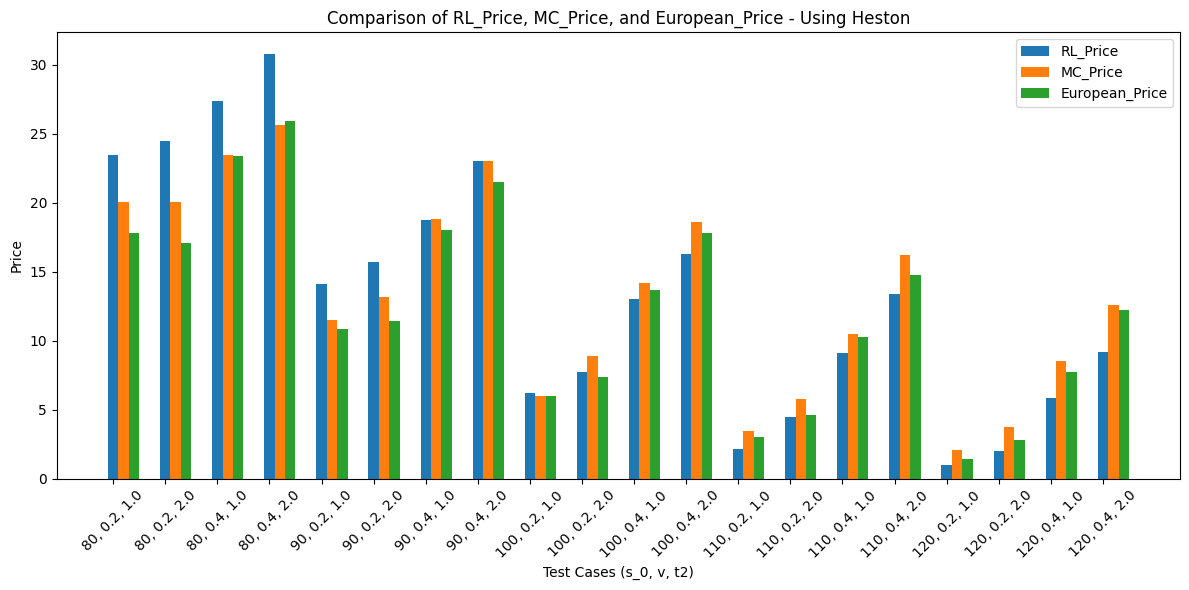

In [49]:
# Relative Performance
plt.figure(figsize=(10, 6))
plt.hist(BC_hest["RL_vs_MC"], bins=10, alpha=0.7, label="RL vs MC", edgecolor="black")
plt.hist(BC_hest["RL_vs_European"], bins=10, alpha=0.7, label="RL vs European", edgecolor="black")
plt.title("Relative Performance of RL_Price vs MC_Price and European_Price - Using Heston")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Comparing RL_Price, MC_Price, and European_Price
plt.figure(figsize=(12, 6))
x = range(len(BC_hest))
plt.bar(x, BC_hest["RL_Price"], width=0.2, label="RL_Price")
plt.bar([i + 0.2 for i in x], BC_hest["MC_Price"], width=0.2, label="MC_Price")
plt.bar([i + 0.4 for i in x], BC_hest["European_Price"], width=0.2, label="European_Price")
plt.xticks(x, [f"{row['s_0']}, {row['sigma']}, {row['t2']}" for _, row in BC_hest.iterrows()], rotation=45)
plt.title("Comparison of RL_Price, MC_Price, and European_Price - Using Heston")
plt.xlabel("Test Cases (s_0, v, t2)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

## Value of Early Excercise

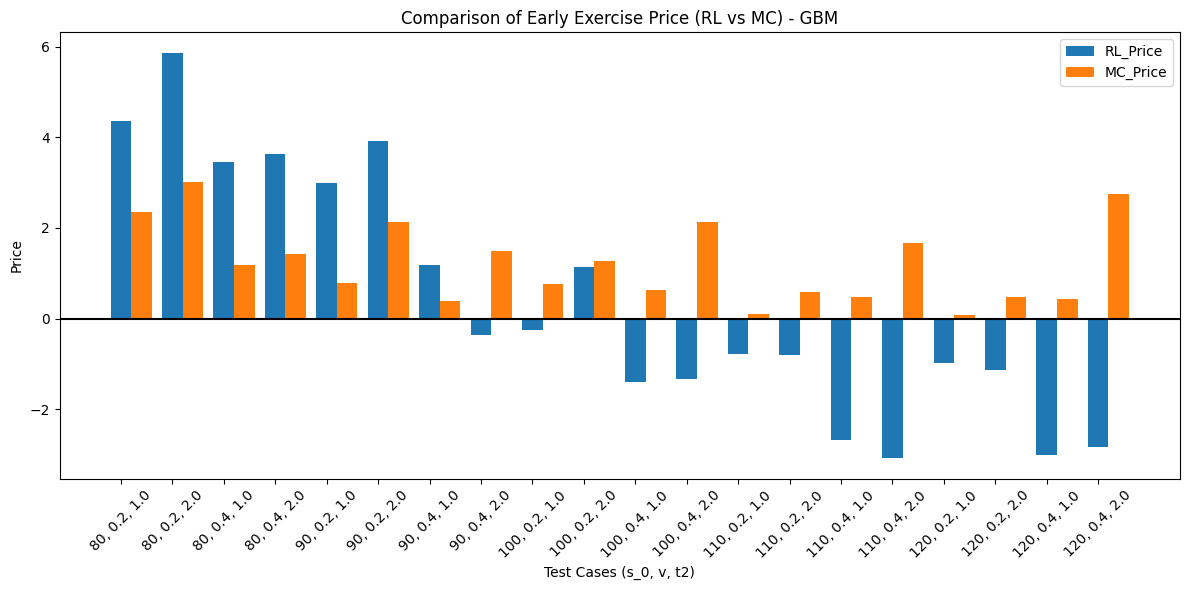

In [ ]:
plt.figure(figsize=(12, 6))
x = range(len(BC_gbm))
plt.bar(x, BC_gbm["Early_Exe_Value_RL"], width=0.4, label="RL_Price")
plt.bar([i + 0.4 for i in x], BC_gbm["Early_Exe_Value_MC"], width=0.4, label="MC_Price")
plt.xticks(x, [f"{row['s_0']}, {row['v']}, {row['t2']}" for _, row in BC_gbm.iterrows()], rotation=45)
plt.title("Comparison of Early Exercise Price (RL vs MC) - GBM")
plt.xlabel("Test Cases (s_0, v, t2)")
plt.axhline(color = "black")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_28065/3525433746.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


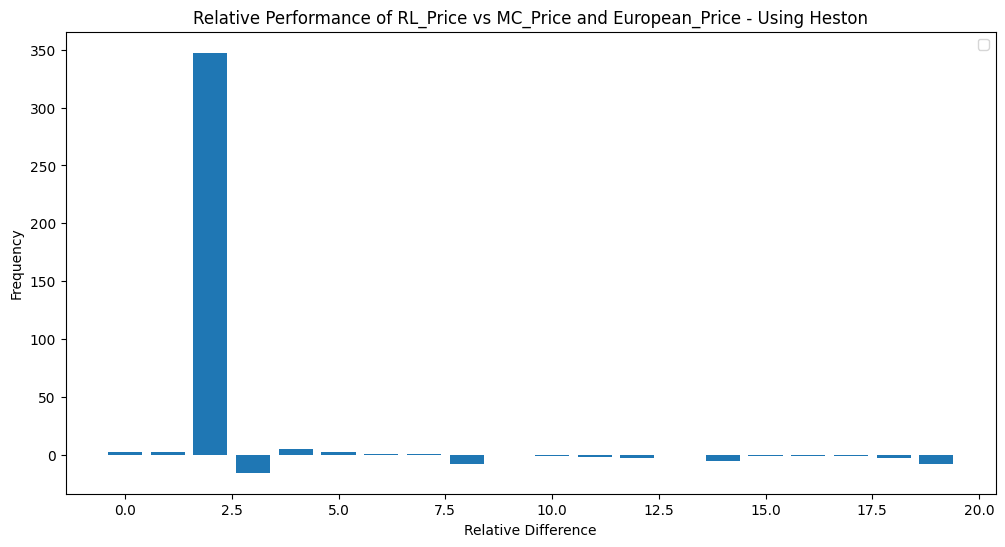

In [47]:
plt.figure(figsize=(12, 6))
x = range(len(BC_hest))
plt.bar(x, BC_hest["Early_Exe_Value_RL"]/BC_hest["Early_Exe_Value_MC"])
#plt.hist(BC_hest["RL_vs_European"], bins=10, alpha=0.7, label="RL vs European", edgecolor="black")
plt.title("Relative Performance of RL_Price vs MC_Price and European_Price - Using Heston")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Testing Dividend Paying Stocks
### K = 100, r = 4%

In [13]:
rel_col2 = ["s_0", "v", "t2", "q", "RL_Price", "European_Price", "MC_Price"]
DP = df[(df["case"] == "Dividend_paying") & (df["gbm"] == True)]
DP[rel_col2]

,s_0,v,t2,q,RL_Price,European_Price,MC_Price
40,100,0.2,1.0,0.01,7.442841,9.319738,9.273495
41,100,0.2,1.0,0.04,7.429718,7.653233,7.965174
42,100,0.2,1.0,0.05,7.076629,7.146642,7.510951
43,100,0.2,1.0,0.30,3.487981,0.765556,2.843164


## Testing High and Zero interest rate environments

In [14]:
rel_col3 = ["s_0", "v", "t2", "r", "RL_Price", "European_Price", "MC_Price"]
HI = df[(df["case"].isin(["High_interest", "Zero_interest" ])) & (df["case"] == "Zero_interest") & (df["gbm"] == True)]
HI[rel_col3]

,s_0,v,t2,r,RL_Price,European_Price,MC_Price
48,100,0.2,1.0,0.0,6.715248,7.965567,8.029768


## Testing Deep ITM and OTM Options

### K = 100, r = 4%

In [15]:
rel_col4 = ["s_0", "v", "t2", "RL_Price", "European_Price", "MC_Price"]
IT = df[(df["case"].isin(["Low S_0", "High S_0"])) & (df["gbm"] == True)]
IT[rel_col4]

,s_0,v,t2,RL_Price,European_Price,MC_Price
53,30,0.2,1.0,0.000000,5.127028e-09,0.000000
54,300,0.2,1.0,204.043944,2.039211e+02,205.784803
55,30,0.2,1.0,70.018525,6.607894e+01,69.992814
56,300,0.2,1.0,0.000000,3.503992e-08,0.000000


## Testing Volitility

### K = 100, r = 4%

In [16]:
rel_col5 = ["s_0", "v", "t2", "RL_Price", "European_Price", "MC_Price"]
VT = df[(df["case"] == "Volatility_stress") & (df["gbm"] == True)]
VT[rel_col5]

,s_0,v,t2,RL_Price,European_Price,MC_Price
49,100,1.00,1.0,44.737504,39.529890,42.522823
50,100,0.01,1.0,1.856378,3.921063,3.905778
51,100,1.00,1.0,28.821353,35.608834,37.046814
52,100,0.01,1.0,0.016956,0.000007,0.046588


## Testing Long and Short maturities

In [17]:
rel_col6 = ["s_0", "v", "t2", "RL_Price", "European_Price", "MC_Price"]
LS = df[(df["case"].isin(["Low_T", "High_T"])) & (df["gbm"] == True)]
LS = LS[rel_col6]

In [18]:
# df[(df["case"] == "Base_Case") ]

In [19]:
# #df[(df["case"] == "Base_Case") & (df["gbm"] == True)]
# df[(df["case"] == "Base_Case") ]

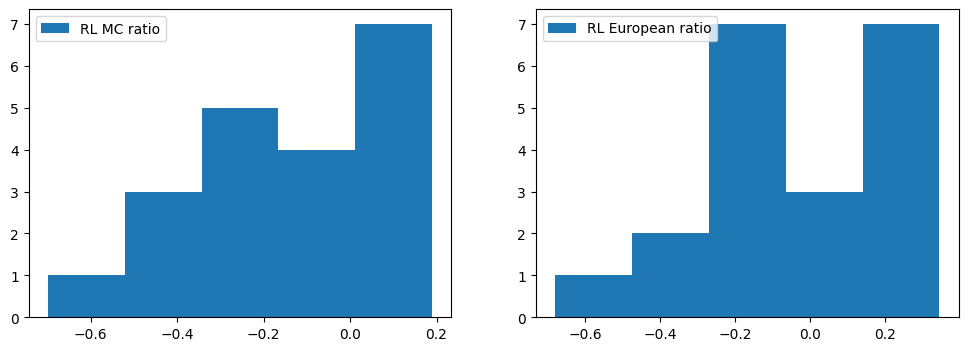

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, col in zip(axes.flatten(), ('MC_Price', 'European_Price')):
    ax.hist((BC_gbm['RL_Price'] - BC_gbm[col]) / BC_gbm[col], bins=5, label=f"RL {col.split('_')[0]} ratio")
    ax.legend()
plt.show()

Plots

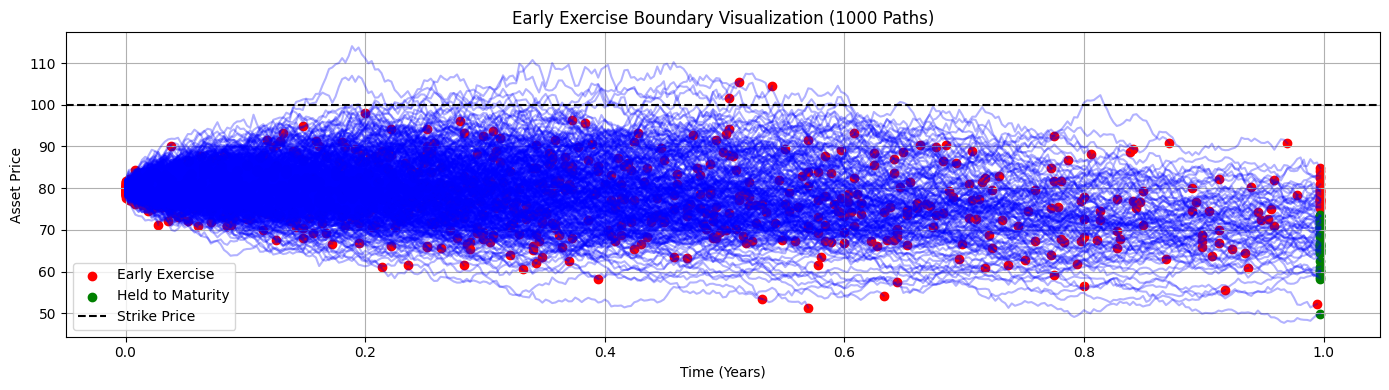

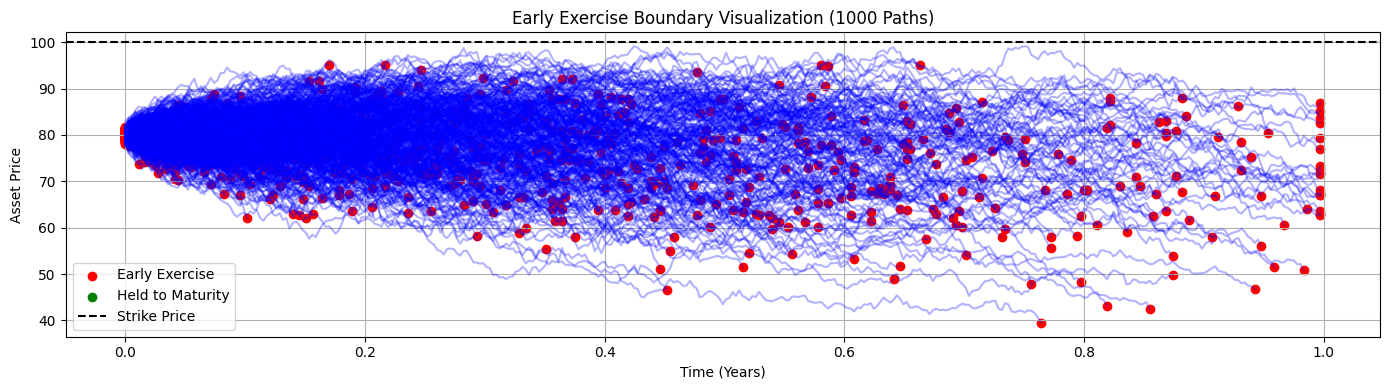

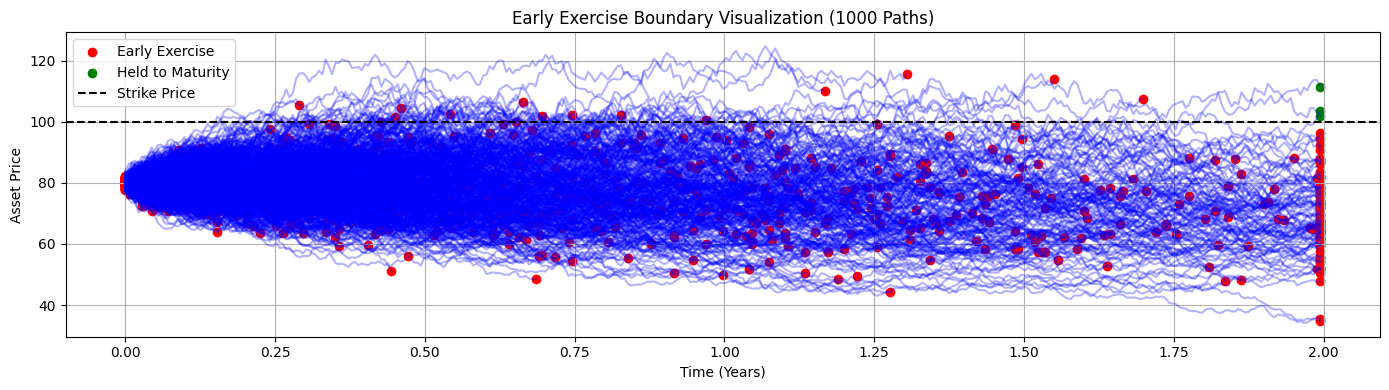

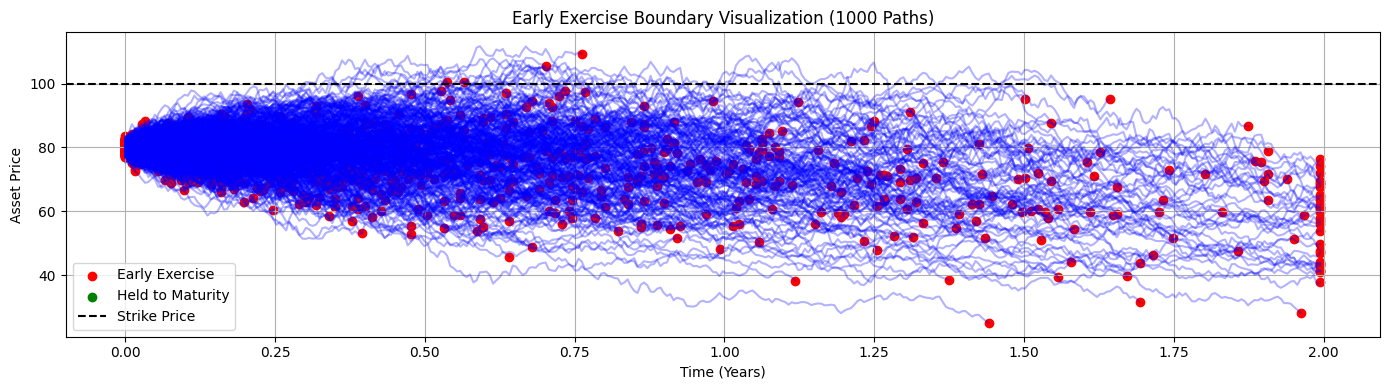

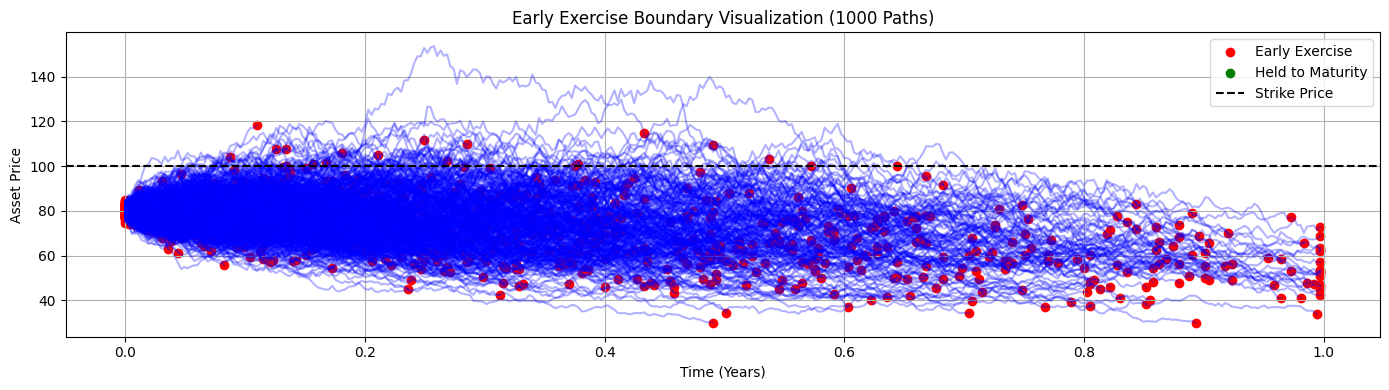

In [26]:
for result in results[:5]:
    mean_reward, fig1, fig2 = result
    show_figure(fig2)

In [22]:
#

Sandbox

In [23]:
# # Function to plot RL, MC, and European prices comparison
# def plot_prices_comparison(df, title="Price Comparison Across Cases"):
#     plt.figure(figsize=(12, 8))
#     x = range(len(df))
#     plt.plot(x, df['RL_Price'], marker='o', label='RL Price', linestyle='-', linewidth=2)
#     plt.plot(x, df['MC_Price'], marker='x', label='MC Price', linestyle='--', linewidth=2)
#     plt.plot(x, df['European_Price'], marker='^', label='European Price', linestyle='-.', linewidth=2)
#     plt.title(title)
#     plt.xlabel("Test Case Index")
#     plt.ylabel("Option Price")
#     plt.legend()
#     plt.show()

# # Function to plot early exercise value comparison
# def plot_early_exercise_comparison(df, title="Early Exercise Value Comparison"):
#     plt.figure(figsize=(12, 8))
#     x = range(len(df))
#     plt.plot(x, df['Early_Exe_Value_RL'], label="Early Exercise Value (RL)", marker='o', linestyle='-', linewidth=2)
#     plt.plot(x, df['Early_Exe_Value_MC'], label="Early Exercise Value (MC)", marker='x', linestyle='--', linewidth=2)
#     plt.title(title)
#     plt.xlabel("Test Case Index")
#     plt.ylabel("Early Exercise Value")
#     plt.legend()
#     plt.show()

# # Plot RL vs MC vs European Prices
# plot_prices_comparison(df, title="Comparison of RL, MC, and European Prices")

# # Plot Early Exercise Values
# plot_early_exercise_comparison(df, title="Comparison of Early Exercise Value (RL vs MC)")


In [24]:
# # Function to compare standardized price differences as a bar plot
# def plot_standardized_price_differences(df, title="Standardized Price Differences: (RL - MC) / MC"):
#     df['Standardized_Diff'] = (df['RL_Price'] - df['MC_Price']) / df['MC_Price']
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=df, x='case', y='Standardized_Diff', ci=None)
#     plt.title(title)
#     plt.xlabel("Test Case Category")
#     plt.ylabel("Standardized Difference: (RL Price - MC Price) / MC Price")
#     plt.xticks(rotation=45)
#     plt.axhline(0, color='black', linewidth=1)  # Reference line at 0
#     plt.show()

# # Plot standardized price differences between RL and MC
# plot_standardized_price_differences(df, title="Standardized Differences Between RL and MC Prices Across Cases")

In [25]:
# def show_fig2_with_params(results, df):
#     for idx, result in enumerate(results):
#         fig2 = result[4] 
#         if fig2 is not None:
#             params = df.iloc[idx]
#             param_text = (
#                 f"So: {params['s_0']}, σ: {params['v'] or params['sigma']}, "
#                 f"T: {params['t2']}, r: {params['r']}, "
#                 f"Option: {params['h']}"
#             )
            
#             fig2.suptitle(param_text, fontsize=10, color='blue')
            
            
#             plt.figure(fig2.number) 
#             show_figure(fig2)

# show_fig2_with_params(results, df)